[CppMonk Tutorial](https://www.youtube.com/playlist?list=PLvKAPIGzFEr8n7WRx8RptZmC1rXeTzYtA)
[HABR1](https://habr.com/ru/articles/166693/)
[HABR](https://habr.com/ru/articles/140274/)
[WIKI](https://en.wikipedia.org/wiki/Kalman_filter)

# Smoothing Kalman

**Goal:** 
estimate $x_t \ & \ v_t$
given measurements $Z = x_t + \epsilon_t$
$$
\begin{align}
X_t = \begin{bmatrix}
   x_{t} \\
   v_{t} \\
 \end{bmatrix} \quad
 Z_t = \begin{bmatrix}
   z_{t} \\
 \end{bmatrix}
\end{align}

$$
**Time evolution**
$$ x_{t+1} = x_t + v_t \delta t + \frac{1}{2}a \delta t^2; \quad  v_{t+1} = v_t + a \delta t$$

$$
X_{t+1} = \begin{bmatrix}
  1 & \delta t \\
  0 & 1 \\
 \end{bmatrix} X_t 
 \ + \ 
 \begin{bmatrix}
  \frac{1}{2}\delta t^2 \\
  \delta t \\
 \end{bmatrix} = F \cdot X_t + G \cdot a 
$$

 **Assumptions:** acceleration and error are noise.
	$$ a, \epsilon \ - \ N(0, \Sigma)$$

$$ 
Z_t = \begin{bmatrix} 1 & 0 \end{bmatrix} X_t + \epsilon_t = H \cdot X_t  + \epsilon_t
$$

**Prediction step**
$$
X_{t} - N(X_t, P_t)
$$
$$
X_{t+1} = F X_t; \quad
P_{t+1} = F P_t F^T + G \Sigma^2_a G^T
$$
**Measurement Step**
$$Y = Z_t - H \cdot X_t \ \text{- error between measurement and prediction}$$
$$S_t = H \cdot P_t \cdot H^T + \Sigma^2_a \text{ - error of covariance estimate}$$
$$ K = P_t \cdot H^T \cdot S^{-1}_t \text{ - optimal Kalman step}$$
$$ X^{udated}_t = X_t + K \cdot Y \text{ - updated location step} $$
$$ P^{updated}_t = [I - K \cdot H] \cdot P_t \text{ - updated covariance} $$


# Cointegration Kalman

**Goal:** 
estimate $x_t \ and \ v_t$ - intercept and $\frac{\sigma_2}{\sigma_1} corr$
assuming that $r_2 = x + v \cdot r_1 + \epsilon^{\prime}$
$$
\begin{align}
X_t = \begin{bmatrix}
   x_{t} \\
   v_{t} \\
 \end{bmatrix} \quad
 Z_t = \begin{bmatrix}
   z_{t} \\
 \end{bmatrix} = r^2_t
\end{align}

$$

**Transition model**
$$ X_{t+1} = F \cdot X_t + \epsilon_x$$
$$ F = \begin{bmatrix}
  1 & 0 \\
  0 & 1 \\
 \end{bmatrix}; 
 \quad \epsilon_x - N(0, Q); 
 \quad Q = \begin{bmatrix}
  \delta_{x} & 0 \\
  0 & \delta_{v} \\
 \end{bmatrix} $$
 
 **Observation Model**	
$$ 
r^2_t = Z_t = H \cdot X_t  + \epsilon_t
$$
$$ H = [1 \quad r^1_t]; \quad \epsilon_x - N(0, R);  \quad R = \begin{bmatrix}
  1 & 0 \\
  0 & 1 \\
 \end{bmatrix}$$
 
**Prediction step**
$$
X_{t} - N(X_t, P_t)
$$
$$
X_{t+1} = F X_t; \quad
P_{t+1} = F P_t F^T + Q
$$

**Measurement Step**
$$Y = Z_t - H \cdot X_t \ \text{- error between measurement and prediction}$$
$$S_t = H \cdot P_t \cdot H^T + R \text{ - error of covariance estimate}$$
$$ K = P_t \cdot H^T \cdot S^{-1}_t \text{ - optimal Kalman step}$$
$$ X^{udated}_t = X_t + K \cdot Y \text{ - updated location step} $$
$$ P^{updated}_t = [I - K \cdot H] \cdot P_t \text{ - updated covariance} $$



In [8]:
import numpy as np
import pandas as pd
from datetime import datetime

import matplotlib.pyplot as plt
%matplotlib inline

Time Series1:  1.2% is missing (428263 ==> 423020)
Time Series2:  0.5% is missing (425135 ==> 423020)


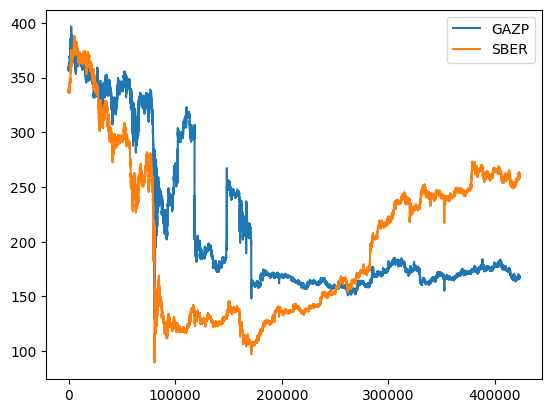

In [9]:
def match_ts(ts1: pd.DataFrame, ts2: pd.DataFrame, join_with: str = None):
    """ Match two Time Series data (DataFrames) by time"""
    init_shape = [ts.shape[0] for ts in [ts1, ts2]]
    ts1 = pd.merge(ts1, ts2['time'], on='time', how='inner')
    ts2 = pd.merge(ts2, ts1['time'], on='time', how='inner')
    res_shape = [ts.shape[0] for ts in [ts1, ts2]]
    pct = [100.0 * round(float(init_shape[i] - res_shape[i]) / init_shape[i], 3) for i in range(2)]
    for i in range(2):
        print(f'Time Series{i+1}:  {pct[i]}% is missing ({init_shape[i]} ==> {res_shape[i]})')
    if join_with is not None:
        res = pd.DataFrame()
        res['time'] = ts1['time']
        res['ts1'] = ts1[join_with]
        res['ts2'] = ts2[join_with]
        return res
    else:
        return ts1, ts2
    
data = pd.read_csv('data/SBER_GAZP.csv')

s1 = data.loc[data['ticker'] == 'GAZP']
s2 = data.loc[data['ticker'] == 'SBER']

s1, s2 = match_ts(s1, s2)

plt.plot(s1['close'], label='GAZP')
plt.plot(s2['close'], label='SBER')
plt.legend()
plt.show()

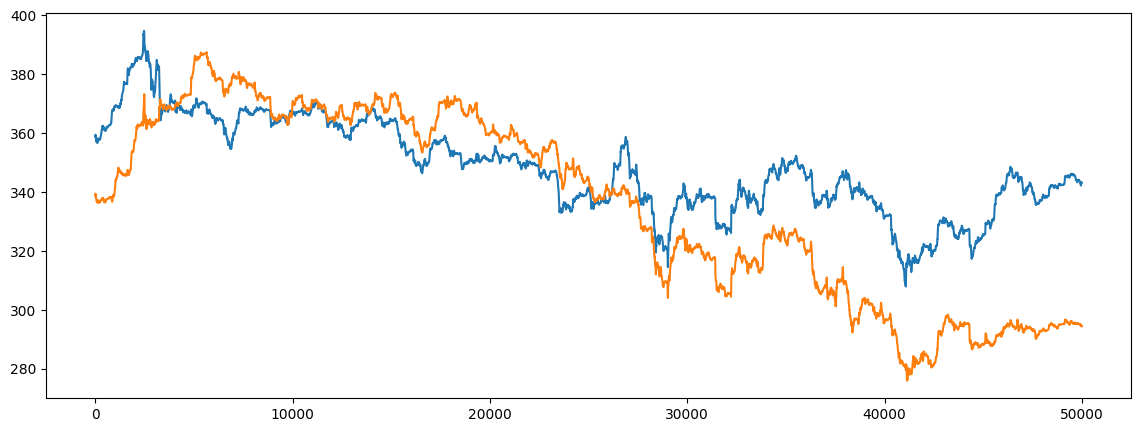

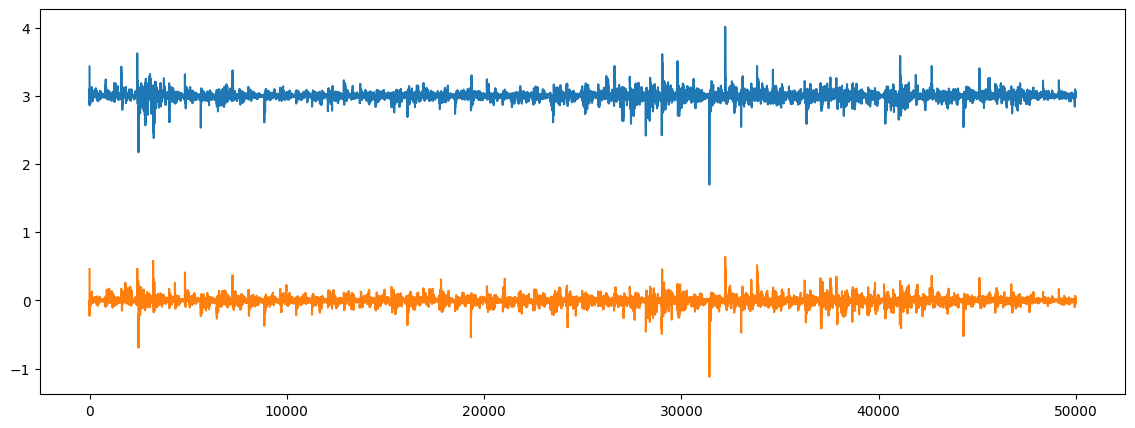

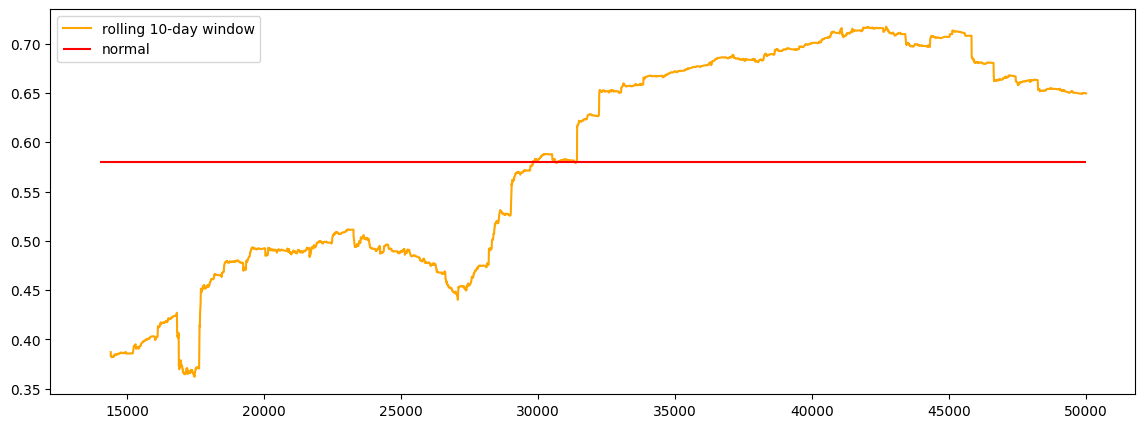

In [10]:
# smoothing
s1 = s1.close.ewm(10).mean()
s2 = s2.close.ewm(10).mean()

plt.figure(figsize=(14, 5))
plt.plot(s1[:50000])
plt.plot(s2[:50000])
plt.show()

ss1 = pd.Series(np.diff(s1.values[:50000]))
ss2 = pd.Series(np.diff(s2.values[:50000]))

plt.figure(figsize=(14, 5))
plt.plot(ss1+3)
plt.plot(ss2)
plt.show()


# plt.plot(ss1, ss2, 'o')
# plt.show()


plt.figure(figsize=(14, 5))
plt.plot(ss1.rolling(10*24*60).corr(ss2)[14000:], label='rolling 10-day window', color='orange')
plt.hlines(np.corrcoef(ss1, ss2)[0][1], xmin=14000, xmax=50000, label='normal', color='red')
plt.legend()
plt.show()